# Loading and concatenating allen gene data

In [4]:
import numpy as np
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [307]:
# Using Pandas to have anice look at some of the raw data
x = glob.glob('/media/mathew/Data_2/Allen_genes/api-examples/structures/raw_expression*')
rows = pd.read_json(x[2])
rows.head()

expression_density  expression_energy         id  \
0            0.053474            8.90860  450107570   
1            0.053474            8.90860  450107573   
2            0.048175            7.88153  450107576   
3            0.044946            7.53617  450107583   
4            0.048972            8.28153  450107588   

                                    section_data_set  section_data_set_id  \
0  {'delegate': False, 'qc_date': '2009-05-02T23:...             74581394   
1  {'delegate': False, 'qc_date': '2009-05-02T23:...             74581394   
2  {'delegate': False, 'qc_date': '2009-05-02T23:...             74581394   
3  {'delegate': False, 'qc_date': '2009-05-02T23:...             74581394   
4  {'delegate': False, 'qc_date': '2009-05-02T23:...             74581394   

   structure_id  sum_expressing_pixel_intensity  sum_expressing_pixels  \
0         15564                     17567800000            105451000.0   
1         15565                     17567800000            105451000.0   
2         15566                     10524900000             64332900.0   
3         15568                       300947000              1794850.0   
4         15569                       120519000               712680.0   

   sum_pixel_intensity    sum_pixels  voxel_energy_cv  voxel_energy_mean  
0          97598900000  1.972000e+09         0.527604            8.89557  
1          97598900000  1.972000e+09         0.527604            8.89557  
2          64605900000  1.335390e+09         0.483118            7.87337  
3           1723840000  3.993370e+07         0.623599            7.54407  
4            671011000  1.455270e+07         0.535451            8.27926

In [9]:
# Python list version of above (instead of pd.dataframe), but loading all of the data (the last file will error as of 20.03.17)
x = glob.glob('/media/mathew/Data_2/Allen_genes/api-examples/structures/raw_expression*')
# x = glob.glob('/Users/mathew/Dropbox/Data/allen_genes/raw_expression*')
my_union = []
# NOTE: first two files are not gene expression, so need to be avoided. Last item is also bad.
# TO DO: change for loop to reflect this - for now just deleting the bad entries posthoc
for i in range(len(x)):
    with open(x[i]) as json_data:
        my_union.append(json.load(json_data))
        

IsADirectoryError: [Errno 21] Is a directory: '/media/mathew/Data_2/Allen_genes/api-examples/structures/raw_expression_json'

In [282]:
# The first two files aren't gene data so delete them
del my_union[0]
del my_union[0]
# my_union[0]

# save 'unionized' data as single json file
f = open('my_unionizes.json', "w")
f.write(json.dumps(my_union))
f.close()


In [15]:
# Load in structure data and dataset list (generated at the bottom of this notebook)
with open('structureIds.json') as json_data:
    structureIds = json.load(json_data)

with open('structHash.json') as json_data:
    structHash = json.load(json_data) 
    
# Change structHash keys back into ints (fixing json pipe 'issue')
structHash = {int(k): v for k,v in structHash.items()}
    
with open('dataSets.json') as json_data:
    dataSets = json.load(json_data) 
# structureIds
# dataSets?

In [110]:
# original version of region x gene indexing, not used.
# sidHash = dict([(id, i) for (i, id) in enumerate(structureIds)])
# didHash = dict([(d['id'], i) for (i, d) in enumerate(mini_data)])

In [70]:
# Generate region x gene index for all available regions and genes in dataset
allIds = [sid for sid, s in structHash.items()]
sidHash_all = dict([(id, i) for (i, id) in enumerate(allIds)])
didHash = {}
for i, us in enumerate(my_union):
    # for each unionize
    for j, u in enumerate(us):
        didHash[u['section_data_set_id']] = i

In [71]:
# Generate expression array and compute pairwise correlations
nstructs = len(allIds)
ndata = len(my_union) #my_union

expression = np.empty([nstructs, ndata])
expression.fill(np.nan)

# For each data set's set of unionizes, then for each individual structure,
# fill in the structure's expression vector.
for i, us in enumerate(my_union):
    # for each unionize
    for j, u in enumerate(us):
        sid = u['structure_id']
        did = u['section_data_set_id']


#         if sidHash.has_key(sid) and didHash.has_key(did):
        if sid in sidHash_all and did in didHash: 
            expression[sidHash_all[sid]][didHash[did]] = u['expression_energy']

# numpy has a masked_array data structure that performs computations while
# filtering out values you don't care about.  In this case, we don't want
# the correlation computation to use NaN's, which indicate that no
# expression was measured for a structure.
mdat = np.ma.masked_array(expression, np.isnan(expression))
corr = np.ma.corrcoef(mdat)


In [82]:
# Save expression data and correlation matrix
f = open('expression.json', "w")
f.write(json.dumps(expression.tolist()))
f.close()

f = open('gene_correlations.json', "w")
f.write(json.dumps(corr.tolist()))
f.close()

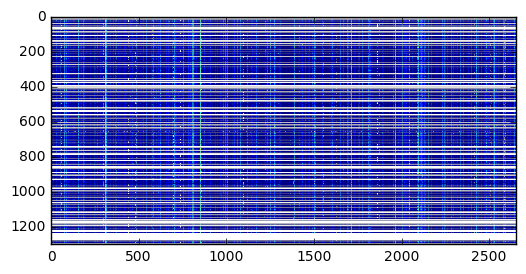

In [72]:
# image plot of expression vectors
np.shape(expression)
plt.imshow(expression)

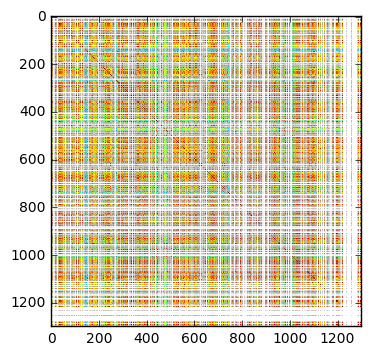

In [73]:
# image of correlation matrix
plt.imshow(corr)

In [135]:
# Generate list of region names/ depths
region_names = [structHash[d]['name'] for d in allIds]  #structureIds
region_depth = [structHash[d]['depth'] for d in allIds] #structureIds

In [152]:
# Compute whether a node is a leaf (no children) or not
leaf_nodes = []
for d in allIds:
    if structHash[d]['num_children'] == 0:
        leaf_nodes.append(1)
    else:
        leaf_nodes.append(0)

In [279]:
# Check the above is consistent
n = 500
print(region_names[n],',',region_depth[n],',',leaf_nodes[n])
structHash[allIds[n]]

Subiculum, dorsal part , 8 , 0


{'acronym': 'SUBd',
 'atlas_id': 346,
 'color_hex_triplet': '4FC244',
 'depth': 8,
 'failed': False,
 'failed_facet': 734881840,
 'graph_id': 1,
 'graph_order': 536,
 'hemisphere_id': 3,
 'id': 509,
 'name': 'Subiculum, dorsal part',
 'neuro_name_structure_id': None,
 'neuro_name_structure_id_path': None,
 'num_children': 3,
 'ontology_id': 1,
 'parent_structure_id': 502,
 'safe_name': 'Subiculum dorsal part',
 'sphinx_id': 537,
 'st_level': None,
 'structure_id_path': [997, 8, 567, 688, 695, 1089, 822, 502, 509],
 'structure_name_facet': 454566553,
 'weight': 8690}

In [182]:
# Generate list of RGB colours per brain region
def hex2rgb(hexcode):
        hexcode = hexcode.lstrip('#')
        return list(int(hexcode[i:i+2],16) for i in (0, 2, 4))
    
region_colours = [hex2rgb(structHash[x]['color_hex_triplet']) for x in allIds]
# region_colours

In [265]:
# Make a list of parent nodes. Save level 3 structure (if available) and level 4 OR cortical region
parent_id = []
subregion_id = []
for x in allIds:
    num_parents = len(structHash[x]['structure_id_path'])-1
    
    subregion= structHash[structHash[x]['structure_id_path'][min(num_parents,4)]]['name']
    semi_parent = structHash[structHash[x]['structure_id_path'][min(num_parents,3)]]['name']
    if num_parents >=6 and structHash[x]['structure_id_path'][3]==688:
        subregion = structHash[structHash[x]['structure_id_path'][6]]['name']                             
    print(subregion,',',semi_parent,',',structHash[x]['name'],',',structHash[x]['depth'])                           
    
    parent_id.append(semi_parent)
    subregion_id.append(subregion)
                    
#     print(structHash[structHash[x]['structure_id_path'][semi_parent]]['name'],',',structHash[x]['name'],',',structHash[x]['depth'])
#     print(structHash[structHash[x]['structure_id_path'][semi_parent]]['name'],structHash[structHash[x]['structure_id_path'][semi_parent2]]['name'])

Hypothalamus , Interbrain , Tuberomammillary nucleus, ventral part , 8
Somatosensory areas , Cerebral cortex , Primary somatosensory area, mouth, layer 6b , 9
secondary fissure , secondary fissure , secondary fissure , 3
Midbrain, sensory related , Midbrain , Inferior colliculus , 5
Hypothalamus , Interbrain , Median eminence , 5
internal capsule , corticospinal tract , internal capsule , 4
Pons , Hindbrain , Principal sensory nucleus of the trigeminal , 6
Basic cell groups and regions , Basic cell groups and regions , Basic cell groups and regions , 1
Somatosensory areas , Cerebral cortex , Primary somatosensory area, trunk, layer 6a , 9
Midbrain, motor related , Midbrain , Superior colliculus, motor related, intermediate gray layer , 6
posterolateral fissure , posterolateral fissure , posterolateral fissure , 3
Midbrain, behavioral state related , Midbrain , Interfascicular nucleus raphe , 6
internal medullary lamina of the thalamus , thalamus related , internal medullary lamina of t

In [275]:
subregion_id
# parent_id

['Hypothalamus',
 'Somatosensory areas',
 'secondary fissure',
 'Midbrain, sensory related',
 'Hypothalamus',
 'internal capsule',
 'Pons',
 'Basic cell groups and regions',
 'Somatosensory areas',
 'Midbrain, motor related',
 'posterolateral fissure',
 'Midbrain, behavioral state related',
 'internal medullary lamina of the thalamus',
 'Thalamus',
 'Cortical subplate',
 'Midbrain, motor related',
 'nodular fissure',
 'Hippocampal region',
 'Retrohippocampal region',
 'lateral olfactory tract, general',
 'Posterior parietal association areas',
 'Striatum',
 'simple fissure',
 'Midbrain, motor related',
 'Thalamus',
 'Retrohippocampal region',
 'lateral spinothalamic tract',
 'Hypothalamus',
 'Anterior cingulate area',
 'Visual areas',
 'intercrural fissure',
 'Midbrain, motor related',
 'Gustatory areas',
 'longitudinal association bundle',
 'Hypothalamus',
 'Anterior cingulate area',
 'Visual areas',
 'Midbrain, motor related',
 'ansoparamedian fissure',
 'Infralimbic area',
 'Medulla

In [281]:
# Save data and labels into matlab formats
import scipy.io as sio
sio.savemat('allen_names.mat',{'allen_names':region_names})
sio.savemat('allen_depth.mat',{'allen_depths':region_depth})
sio.savemat('allen_CC.mat',{'allen_cc':corr.data})
sio.savemat('allen_expression.mat',{'allen_expression':expression})
sio.savemat('allIds.mat',{'allIds':allIds})

sio.savemat('allen_colours.mat',{'allen_colours':region_colours})
sio.savemat('allen_leafnodes.mat',{'allen_leafnodes':leaf_nodes})

sio.savemat('allen_parents.mat',{'allen_parents':parent_id})
sio.savemat('allen_subregion.mat',{'allen_subregion':subregion_id})

### Some code for looking at slices of the data

In [288]:
# pandas version of the structure dataset for prettier printing of data rows
structDF = pd.DataFrame.from_dict(structHash,orient='index')

In [292]:
# Find the Zona Incerta
structDF[structDF.acronym == 'ZI']

color_hex_triplet  parent_structure_id  ontology_id  weight acronym  \
797            F2483B                290.0            1    8690      ZI   

     sphinx_id failed  structure_name_facet  atlas_id  depth      ...       \
797        790  False            3420252476     382.0      6      ...        

        safe_name  graph_id num_children  neuro_name_structure_id  \
797  Zona incerta         1            2                     None   

     graph_order neuro_name_structure_id_path  \
797          789                         None   

                       structure_id_path st_level failed_facet          name  
797  [997, 8, 343, 1129, 1097, 290, 797]      NaN    734881840  Zona incerta  

[1 rows x 22 columns]

In [300]:
# Find the direct children of ZI
structDF[structDF.parent_structure_id == 797]

color_hex_triplet  parent_structure_id  ontology_id  weight acronym  \
796            F2483B                797.0            1    8690     A13   
804            F2483B                797.0            1    8690      FF   

     sphinx_id failed  structure_name_facet  atlas_id  depth  \
796        791  False            4064653384     806.0      7   
804        792  False              89343914     807.0      7   

              ...                         safe_name  graph_id num_children  \
796           ...            Dopaminergic A13 group         1            0   
804           ...                   Fields of Forel         1            0   

     neuro_name_structure_id  graph_order neuro_name_structure_id_path  \
796                     None          790                         None   
804                     None          791                         None   

                            structure_id_path st_level failed_facet  \
796  [997, 8, 343, 1129, 1097, 290, 797, 796]      NaN    734881840   
804  [997, 8, 343, 1129, 1097, 290, 797, 804]      NaN    734881840   

                       name  
796  Dopaminergic A13 group  
804         Fields of Forel  

[2 rows x 22 columns]

In [297]:
# List structure id path e.g. for ZI
structHash[797]['structure_id_path']
# structHash[688]['name']

[997, 8, 343, 1129, 1097, 290, 797]

In [301]:
# Print whole structure id path for a given region
# ZI: 797. 688: Cerebral cortex. 2: low level structure in S1
for p in structHash[797]['structure_id_path']:
    print(p,':',structHash[p]['name'])

997 : root
8 : Basic cell groups and regions
343 : Brain stem
1129 : Interbrain
1097 : Hypothalamus
290 : Hypothalamic lateral zone
797 : Zona incerta


## Load gene dataset list, save gene labels + names

In [302]:
# load gene dataset list with pandas
gene_list = pd.read_csv('/home/mathew/work/NetworkNoiseRejection/Networks/Allen_mouse_brain_atlas/mouse_expression_data_sets.csv')
gene_list.head()

data_set_id  gene_id gene_symbol  \
0            3    43669      Snap47   
1            5    43302         Nvl   
2            6    43302         Nvl   
3            7    47593      Gtf3c2   
4            8    47593      Gtf3c2   

                                           gene_name probe_id  \
0                synaptosomal-associated protein, 47     6907   
1                                   nuclear VCP-like   253948   
2                                   nuclear VCP-like   253948   
3  general transcription factor IIIC, polypeptide...   103279   
4  general transcription factor IIIC, polypeptide...   103279   

         probe_name orientation plane_of_section  \
0  RP_040324_01_E07   Antisense          coronal   
1  RP_Baylor_253948   Antisense          coronal   
2  RP_Baylor_253948   Antisense         sagittal   
3  RP_Baylor_103279   Antisense          coronal   
4  RP_Baylor_103279   Antisense         sagittal   

                                       grid_file_url  \
0  http://download.alleninstitute.org/informatics...   
1  http://download.alleninstitute.org/informatics...   
2  http://download.alleninstitute.org/informatics...   
3  http://download.alleninstitute.org/informatics...   
4  http://download.alleninstitute.org/informatics...   

                        structure_unionizes_file_url Unnamed: 10 Unnamed: 11  \
0  http://download.alleninstitute.org/informatics...         NaN         NaN   
1  http://download.alleninstitute.org/informatics...         NaN         NaN   
2  http://download.alleninstitute.org/informatics...         NaN         NaN   
3  http://download.alleninstitute.org/informatics...         NaN         NaN   
4  http://download.alleninstitute.org/informatics...         NaN         NaN   

  Unnamed: 12 Unnamed: 13 Unnamed: 14  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN

In [305]:
# for all datasets in my_union, work out the gene symbol and it's name
gene_name = []
gene_desc = []
for i, x in enumerate(didHash):
    g = gene_list[gene_list.data_set_id == my_union[i][0]['section_data_set_id']].gene_symbol.values
    n = gene_list[gene_list.data_set_id == my_union[i][0]['section_data_set_id']].gene_name.values
    print(g,n)
    gene_name.append(g)
    gene_desc.append(n)

['Pltp'] ['phospholipid transfer protein']
['Gm626'] ['predicted gene 626']
['Rasal1'] ['RAS protein activator like 1 (GAP1 like)']
['St8sia6'] ['ST8 alpha-N-acetyl-neuraminide alpha-2,8-sialyltransferase 6']
['Tsc22d2'] ['TSC22 domain family, member 2']
['Mlx'] ['MAX-like protein X']
['Kit'] ['kit oncogene']
['Rasl11a'] ['RAS-like, family 11, member A']
['Doc2b'] ['double C2, beta']
['Pip5k1c'] ['phosphatidylinositol-4-phosphate 5-kinase, type 1 gamma']
['BC034076'] ['cDNA sequence BC034076']
['Tmem215'] ['transmembrane protein 215']
['Oprk1'] ['opioid receptor, kappa 1']
['Kctd6'] ['potassium channel tetramerisation domain containing 6']
['Calb2'] ['calbindin 2']
['Apbb3'] ['amyloid beta (A4) precursor protein-binding, family B, member 3']
['Igfn1'] ['immunoglobulin-like and fibronectin type III domain containing 1']
['Acsl5'] ['acyl-CoA synthetase long-chain family member 5']
['Wnt7b'] ['wingless-related MMTV integration site 7B']
['Doc2a'] ['double C2, alpha']
['Anxa3'] ['annexin A

In [306]:
# Save into matlab formats
sio.savemat('allen_genes.mat',{'allen_genes':gene_name})
sio.savemat('allen_gene_desc.mat',{'allen_gene_desc':gene_desc})

# APPENDIX: code to download all the data
## NOTE: expression data will take a long time to download...

In [5]:
# Initialise libraries, set dataset paths and generate queries
API_PATH = "http://api.brain-map.org/api/v2/data"
GRAPH_ID = 1
MOUSE_PRODUCT_ID = 1 # aba
PLANE_ID = 1 # coronal
TOP_N = 20000

DATA_SET_QUERY_URL = ("%s/SectionDataSet/query.json" +\
                          "?criteria=[failed$eq'false'][expression$eq'true']" +\
                          ",products[id$eq%d]" +\
                          ",plane_of_section[id$eq%d]") \
                          % (API_PATH, MOUSE_PRODUCT_ID, PLANE_ID)

UNIONIZE_FMT = "%s/StructureUnionize/query.json" +\
    "?criteria=[section_data_set_id$eq%d]" +\
    "&include=section_data_set(products[id$eq%d])" % (MOUSE_PRODUCT_ID)

STRUCTURES_URL = ("%s/Structure/query.json?" +\
                      "criteria=[graph_id$eq%d]") \
                      % (API_PATH, GRAPH_ID)

import json
import sys
import os
import string

from urllib.request import urlopen

def QueryAPI(url):
    start_row = 0
    num_rows = 20000
    total_rows = -1
    rows = []
    done = False
    
    while not done:
        pagedUrl = url + '&start_row=%d&num_rows=%d' % (start_row,num_rows)

        print(pagedUrl)
        source = urlopen(pagedUrl).read().decode('utf8') # py3
#         source = urllib.urlopen(pagedUrl).read()

        response = json.loads(source)
        rows += response['msg']
        
        if total_rows < 0:
            total_rows = int(response['total_rows'])

        start_row += len(response['msg'])

        if start_row >= total_rows:
            done = True

    return rows

In [6]:
# Download and save dataset list
def DownloadDataSets(n):
    dataSets = QueryAPI(DATA_SET_QUERY_URL)
  
    if n <= 0:
        return dataSets
    else:
        n = min(len(dataSets), n)

    return dataSets[:n]

n = -1
dataSets = DownloadDataSets(n)

f = open('dataSets.json', "w")
f.write(json.dumps(dataSets))
f.close()

http://api.brain-map.org/api/v2/data/SectionDataSet/query.json?criteria=[failed$eq'false'][expression$eq'true'],products[id$eq1],plane_of_section[id$eq1]&start_row=0&num_rows=20000


In [64]:
# Download and save structure data

def DownloadStructures():
    structs = QueryAPI(STRUCTURES_URL)

    # Build a dict from structure id to structure and identify each node's
    # direct descendants.
    structHash = {}
    for s in structs:
        s['num_children'] = 0
        s['structure_id_path'] = [
            int(sid) for sid in s['structure_id_path'].split('/') if sid != '']
        structHash[s['id']] = s

        # python 3 renamed iteritems to items
    for sid, s in structHash.items():
        if len(s['structure_id_path']) > 1:
            parentId = s['structure_id_path'][-2]
            structHash[parentId]['num_children'] += 1

    # pull out the structure ids for structures in this structure graph that
    # have no children (i.e. just the leaves)
    corrStructIds = [sid for sid, s in structHash.items() if s[
        'num_children'] == 0]

    return sorted(corrStructIds), structHash

structureIds, structHash = DownloadStructures()

# Save structureIds and structHash
f = open('structureIds.json', "w")
f.write(json.dumps(structureIds))
f.close()

f = open('structHash.json', "w")
f.write(json.dumps(structHash))
f.close()

http://api.brain-map.org/api/v2/data/Structure/query.json?criteria=[graph_id$eq1]&start_row=0&num_rows=20000


In [33]:
# Download expression data, but save as you go
def QueryAPI_saving(url,f_id):
    start_row = 0
    num_rows = 20000
    total_rows = -1
    rows = []
    done = False
    
    while not done:
        pagedUrl = url + '&start_row=%d&num_rows=%d' % (start_row,num_rows)

        print(pagedUrl)
        source = urlopen(pagedUrl).read().decode('utf8') # py3
#         source = urllib.urlopen(pagedUrl).read()

        response = json.loads(source)
        rows += response['msg']
        
        if total_rows < 0:
            total_rows = int(response['total_rows'])

        start_row += len(response['msg'])

        if start_row >= total_rows:
            done = True
            
            # Parse url to get dataset name
            
            
            print(f_id)
            fname = "expression_"+ f_id +".json"
            # save as you go
            f = open(fname,"w")
            f.write(json.dumps(rows))
            f.close()
            

    return rows

In [30]:
# Download expression data and save as you go.
def DownloadExpression(dataSets):
    return [QueryAPI_saving(UNIONIZE_FMT % (API_PATH,d['id']),str(d['id'])) for d in dataSets]
#     return [QueryAPI(UNIONIZE_FMT % (API_PATH,d['id'])) for d in dataSets]

In [109]:
# example small download
mini_data = dataSets[:5]
unionizes = DownloadExpression(mini_data)

http://api.brain-map.org/api/v2/data/StructureUnionize/query.json?criteria=[section_data_set_id$eq74581394]&include=section_data_set(products[id$eq1])&start_row=0&num_rows=20000
74581394
http://api.brain-map.org/api/v2/data/StructureUnionize/query.json?criteria=[section_data_set_id$eq73931634]&include=section_data_set(products[id$eq1])&start_row=0&num_rows=20000
73931634
http://api.brain-map.org/api/v2/data/StructureUnionize/query.json?criteria=[section_data_set_id$eq75774111]&include=section_data_set(products[id$eq1])&start_row=0&num_rows=20000
75774111
http://api.brain-map.org/api/v2/data/StructureUnionize/query.json?criteria=[section_data_set_id$eq73929596]&include=section_data_set(products[id$eq1])&start_row=0&num_rows=20000
73929596
http://api.brain-map.org/api/v2/data/StructureUnionize/query.json?criteria=[section_data_set_id$eq74958463]&include=section_data_set(products[id$eq1])&start_row=0&num_rows=20000
74958463
